<a href="https://colab.research.google.com/github/umar006/image-classification-pytorch/blob/main/expo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install flickrapi

import os, shutil, tarfile, time, requests, sys, csv, copy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
# from flickrapi import FlickrAPI
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

torch.manual_seed(123)

# Download dataset
Scraping images from Flickr website using Flickr API, image tag that used to scrape for vehicles dataset

1.   Airplane
2.   Train
3.   Car
4.   Motorcycle
5.   Bicycle
6.   Bus
7.   Truck
8.   Scooter
9.   Helicopter
10.  Ship

Each tag have > 900 images with total > 9k images.


In [ ]:
key="a1418519e8ce671c68f877f1401dde5f"
secret="343877ee8ed9fbba"
def get_urls(image_tag, MAX_COUNT):
    flickr = FlickrAPI(key, secret)
    photos = flickr.walk(text=image_tag,
                            tag_mode='all',
                            tags=image_tag,
                            extras='url_c',
                            per_page=50,
                            sort='relevance')
    count=0
    urls=[]
    for photo in photos:
        if count< MAX_COUNT:
            count=count+1
            print("Fetching url for image number {}".format(count))
            try:
                url=photo.get('url_c')
                urls.append(url)
            except:
                print("Url for image number {} could not be fetched".format(count))
        else:
            print("Done fetching urls, fetched {} urls out of {}".format(len(urls),MAX_COUNT))
            break
    urls=pd.Series(urls)
    print("Writing out the urls in the current directory")
    urls.to_csv(image_tag+"_urls.csv")
    print("Done!!!")

def put_images(FILE_NAME):
    urls=[]
    with open(FILE_NAME,newline="") as csvfile:
        doc=csv.reader(csvfile,delimiter=",")
        for row in doc:
            if row[1].startswith("https"):
                urls.append(row[1])
    if not os.path.isdir(os.path.join(os.getcwd(),FILE_NAME.split("_")[0])):
        os.mkdir(FILE_NAME.split("_")[0])
    t0=time.time()
    
    for url in enumerate(urls):
        print("Starting download {} of ".format(url[0]+1),len(urls))
        try:
            resp=requests.get(url[1],stream=True)
            path_to_write=os.path.join(os.getcwd(),FILE_NAME.split("_")[0],url[1].split("/")[-1])
            outfile=open(path_to_write,'wb')
            outfile.write(resp.content)
            outfile.close()
            print("Done downloading {} of {}".format(url[0]+1,len(urls)))
        except:
            print("Failed to download url number {}".format(url[0]))
    t1=time.time()
    print("Done with download, job took {} seconds".format(t1-t0))

# Cleaning dataset
check if file cannot used to train with Image function from PIL library.
if file got *UnidentifiedImageError*, the file need to deleted

In [ ]:
def clean_file(path: list, del_file=False):
  '''
  Delete image file that can not open with Image function from PIL library

  Param:
  path -> list: full path image
  del_file -> bool: delete image if True otherwise pass
  '''
  for p in path:
    try:
      img = Image.open(p)
    except:
      file = p.split('/')[-1]
      print(f"file {file} cannot open")

      if del_file:
        os.remove(p)
        print(f"file {file} has been deleted")
  print('Done!')

# Visualize dataset

In [ ]:
"""Ubah root_dir ke folder vehicles di shared folder google drive"""
root_dir = '/content/drive/MyDrive/dataset/'
vehicles_dir = os.path.join(root_dir, 'vehicles')
flowers_dir = os.path.join(root_dir, 'flowers')

# VEHICLE
cls_vh = [i for i in os.listdir(vehicles_dir) if os.path.isdir(os.path.join(vehicles_dir, i))]
cls_vh = [i for i in cls_vh if i != 'training' and i != 'validation']
value_vh = [len(os.listdir(os.path.join(vehicles_dir, i))) for i in cls_vh]

# FLOWERS
cls_fl = [i for i in os.listdir(flowers_dir) if os.path.isdir(os.path.join(flowers_dir, i))]
cls_fl = [i for i in cls_fl if i != 'training' and i != 'validation']
value_fl = [len(os.listdir(os.path.join(flowers_dir, i))) for i in cls_fl]

FileNotFoundError: ignored

Text(0, 0.5, 'Total')

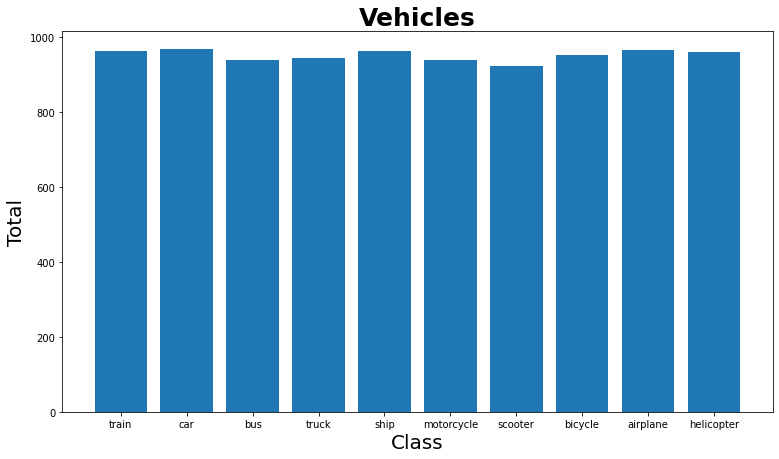

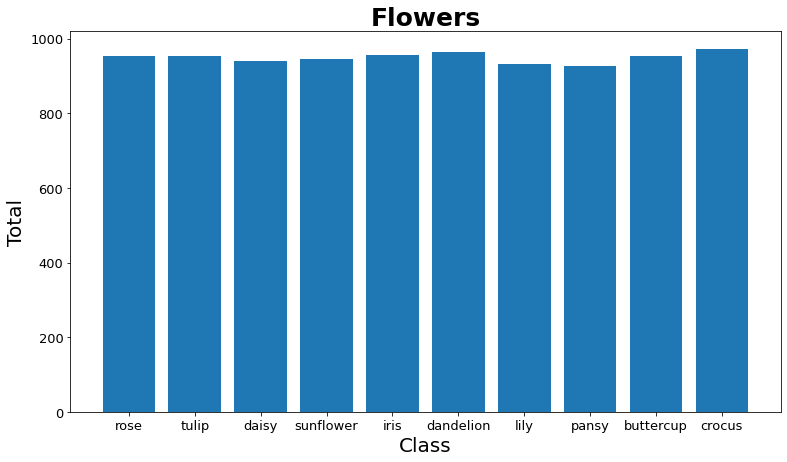

In [ ]:
# VEHICLES
plt.figure(figsize=(28, 7))
plt.subplot(121)
plt.title('Vehicles', fontdict={'fontsize': 25, 'fontweight':'bold'})
plt.bar(cls_vh, value_vh)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.xlabel('Class', fontdict={'fontsize': 20})
plt.ylabel('Total', fontdict={'fontsize': 20})

# FLOWERS
plt.figure(figsize=(28, 7))
plt.subplot(122)
plt.title('Flowers', fontdict={'fontsize': 25, 'fontweight':'bold'})
plt.bar(cls_fl, value_fl)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.xlabel('Class', fontdict={'fontsize': 20})
plt.ylabel('Total', fontdict={'fontsize': 20})

# Split images
Split dataset to train, validation \
```
images
  |_cls1
  |_cls2
  |_...
```
to
```
training
  |_cls1
  |_cls2
  |_...
validation
  |_cls1
  |_cls2
  |_...
```




In [ ]:
def split_folders(path, valid_size=0.2):
  classes = [i for i in os.listdir(path) if os.path.isdir(os.path.join(path, i))]

  train_dir = os.path.join(path, 'training')
  valid_dir = os.path.join(path, 'validation')

  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(valid_dir, exist_ok=True)

  for cls in classes:
    cls_path = os.path.join(path, cls)
    train, valid = train_test_split(os.listdir(cls_path), test_size=valid_size, shuffle=True, random_state=123)

    train_cls_path = os.path.join(train_dir, cls)
    valid_cls_path = os.path.join(valid_dir, cls)
    os.makedirs(train_cls_path, exist_ok=True)
    os.makedirs(valid_cls_path, exist_ok=True)

    for file in os.listdir(cls_path):
      src = os.path.join(cls_path, file)
      t_dest = os.path.join(train_cls_path, file)
      v_dest = os.path.join(valid_cls_path, file)
      if file in train:
        shutil.copyfile(src, t_dest)
      else:
        shutil.copyfile(src, v_dest)
    print(f'{cls} - done')

  print('Done!')

# Data augmentation

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (128, 128)

img_transformation = {
      "training": transforms.Compose([
          transforms.Resize(IMG_SIZE),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(128, padding=4),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
      ]),
      "validation": transforms.Compose([
          transforms.Resize(IMG_SIZE),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
      ])
}

data_dir = {'vehicles': {'training': os.path.join(vehicles_dir, 'training'),
                         'validation': os.path.join(vehicles_dir, 'validation')},
            'flowers': {'training': os.path.join(flowers_dir, 'training'),
                        'validation': os.path.join(flowers_dir, 'validation')}}


# Vehicles dataset
train_vehicles_ds = datasets.ImageFolder(data_dir['vehicles']['training'], transform=img_transformation['training'])
valid_vehicles_ds = datasets.ImageFolder(data_dir['vehicles']['validation'], transform=img_transformation['validation'])

# # Flowers dataset
train_flowers_ds = datasets.ImageFolder(data_dir['flowers']['training'], transform=img_transformation['training'])
valid_flowers_ds = datasets.ImageFolder(data_dir['flowers']['validation'], transform=img_transformation['validation'])

# Concenate two datasets (Vehicles and Flowers)
train_mix_ds = train_vehicles_ds + train_flowers_ds
valid_mix_ds = valid_vehicles_ds + valid_flowers_ds

# # Concenate dataloader
train_loader = DataLoader(train_mix_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_mix_ds, batch_size=BATCH_SIZE * 2, shuffle=False)

class_list = train_vehicles_ds + train_flowers_ds
classes = {i:j for i,j in enumerate(sorted(class_list))}
classes

# Architecture

In [ ]:
def conv_block(in_f, out_f):
  return nn.Sequential(
      nn.Conv2d(in_f, out_f, kernel_size=3, padding=1),
      nn.SELU()
  )

class VehicleNet(nn.Module):
  def __init__(self):
    super(VehicleNet, self).__init__()

    self.encoder = nn.Sequential(
      conv_block(3, 16),
      conv_block(16, 16),
      nn.MaxPool2d(3, padding=1),
      conv_block(16, 16),
      nn.MaxPool2d(3, padding=1),
      conv_block(16, 32),
      nn.MaxPool2d(3, padding=1),
    )

    self.decoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(5 * 5 * 32, 128),
      nn.Dropout(0.5),
      nn.Linear(128, 10)
    )

  def forward(self, input):
    output = self.encoder(input)
    output = self.decoder(output)

    return F.softmax(output, 1)

# Training

In [ ]:
def valid(model):
  model.eval()
  with torch.no_grad():
    valid_acc = 0.0
    for i, (images, labels) in enumerate(valid_loader):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)

      prediction = torch.argmax(outputs, 1)
      valid_acc += torch.sum(prediction == labels.data)

    # calculate validation accuracy
    valid_acc = valid_acc / len(valid_mix_ds)
    return valid_acc

def train(num_epochs, model, criterion, optimizer):
  best_acc = 0.0
  train_acc = 0.0
  train_loss = 0.0

  for epoch in range(num_epochs):
    # get start training time
    start = time.time()

    # training model
    model.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.cuda(), labels.cuda()
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward propagation
      outputs = model(images)
      prediction = torch.argmax(outputs, 1)
      loss = criterion(outputs, labels)

      # backward propagation + optimize
      loss.backward()
      optimizer.step()

      # statistics
      train_loss += loss.item() * images.size(0)
      train_acc += torch.sum(prediction == labels.data)

      if i % 50 == 0:
        print(loss.item())
    
    # calculate training loss and accuracy
    train_loss = train_loss / len(train_mix_ds)
    train_acc = train_acc / len(train_mix_ds)

    # evaluate model
    valid_acc = valid(model)

    # get end training time
    stop = time.time()

    # save the model if valid acc > best acc
    if valid_acc > best_acc:
      # remove best model that saved before
      if os.path.exists(f"vehiclesmodel{best_acc*100:.0f}(full).pth"):
        os.remove(f"vehiclesmodel{best_acc*100:.0f}(full).pth")
        os.remove(f"vehiclesmodel{best_acc*100:.0f}(state_dict).pth")
        
      best_acc = valid_acc

      # save state_dict model
      torch.save(model, f"vehiclesmodel{best_acc*100:.0f}(full).pth")
      # save entire model
      torch.save(model.state_dict(), f"vehiclesmodel{best_acc*100:.0f}(state_dict).pth")
      print("Checkpoint saved")

    print(f"time: {round(stop - start)}s\tepoch: {epoch + 1}\ttrain_loss: {train_loss:.5f}\ttrain_acc: {train_acc:.5f}\tvalid_acc: {valid_acc:.5f}")

## w/o TL

In [ ]:
model = VehicleNet().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time

train(20, model, criterion, optimizer)

## w TL
Use resnet18 as pretrained model with 20 classes

In [ ]:
from torchvision.models import resnet18

model_ft = resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 20)
model_ft = model_ft.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.0001)

train(10, model_ft, criterion, optimizer)

# Testing

In [ ]:
checkpoint = torch.load('mixmodel97(state_dict).pth', map_location=torch.device('cpu'))
model_test = model_ft
model_test.load_state_dict(checkpoint)
model_test.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 42.jpeg to 42.jpeg


In [ ]:
for i, fn in enumerate(uploaded.keys()):
  img = Image.open(fn)
  img_trans = img_transformation['validation'](img)
  output = model_test(img_trans.unsqueeze(0))
  pred = torch.argmax(output, 1)
  print(pred)
  # plt.subplot(1, 3, 1+i)
  # plt.imshow(img)
  # plt.subplots_adjust(right=3, top=5, bottom=2)
  # plt.title(train_vehicles_ds.classes[pred])

tensor([16])
